In [96]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

The aim of this exercise is to plot the hydrological data of our basin into the Budyko Framework and doing so to understand the losses in the general water balance. The data we used for this exercise are evaporation and precipitation data forced thanks to the ESMValTool (2000-2019). We calculated the evaporation fraction EA/P firstly from the runoff ratio Q/P (EA/P = 1 - Q/P) using the mean values of our time series of forcing data (method derived from the water balance) and subsequently using the Budyko formula, using the known aridity index EP/P.

## Reading data

In [97]:
import xarray as xr

filename = "OBS6_ERA5_reanaly_1_day_pr_2000-2018_newbasin.nc"  # Update the path to the correct location of the file
# Read the NetCDF file
ds = xr.open_dataset(filename)
# Convert to a pandas DataFrame
df = ds.to_dataframe()
# Reset the index if needed
df.reset_index(inplace=True)
df = df[df['bnds'] == 0]
df.index = pd.to_datetime(df['time'])
df.index = df.index.normalize()
df.drop(columns=['time', 'bnds'], inplace=True)
prec  = df['pr']  # Precipitation data
prec  = prec*86400  # Convert from m/s to mm/day)
prec[prec < 0] = 0  # Set negative values to zero
prec


time
2000-01-01    0.004437
2000-01-02    0.000000
2000-01-03    0.020500
2000-01-04    0.000000
2000-01-05    0.000000
                ...   
2018-12-27    0.000153
2018-12-28    0.043055
2018-12-29    0.054359
2018-12-30    0.000814
2018-12-31    0.000000
Freq: D, Name: pr, Length: 6940, dtype: float64

In [98]:
filename = "Derived_Makkink_evspsblpot_newbasin.nc"  # Update the path to the correct location of the file
# Read the NetCDF file
dsEP = xr.open_dataset(filename)
# Convert to a pandas DataFrame
dfEP = dsEP.to_dataframe()
# Reset the index if needed
dfEP.reset_index(inplace=True)
EP = dfEP['evspsblpot']  # Evapotranspiration data
EP.index = pd.to_datetime(dfEP['time'])
EP.index = EP.index.normalize()  # Ensure index is of type pd.Timestamp and remove the time part
EP = EP * 86400  # Convert from mm/s to mm/day
EP[EP < 0] = 0  # Set negative values to zero
EP.loc[EP.index >= pd.Timestamp('2017-09-30')]  # Use pd.Timestamp for comparison

time
2017-09-30    2.317320
2017-10-01    2.425956
2017-10-02    2.322404
2017-10-03    2.964771
2017-10-04    3.071429
                ...   
2018-12-27    1.134647
2018-12-28    0.905379
2018-12-29    0.937707
2018-12-30    1.223050
2018-12-31    1.240412
Freq: D, Name: evspsblpot, Length: 458, dtype: float64

In [99]:
filename = "Upstream_Q.txt"
A = 17002.553 *10**6 #m^2
dfQ = pd.read_csv(filename, delim_whitespace=True, skiprows=1, header=None, encoding='latin1')  # Specify encoding
dfQ = dfQ[[0, 3]]  # Select only the first and third columns
dfQ.columns = ['Date', 'Q']  # Rename columns for clarity
dfQ['Date'] = pd.to_datetime(dfQ['Date'], format='%Y-%m-%d')  # Convert 'Date' column to datetime
dfQ.set_index('Date', inplace=True)  # Set 'Date' as the index
dfQ['Q'] = (dfQ['Q']/A)*1000 #mm/day
dfQ 

C:\Users\margh\AppData\Local\Temp\ipykernel_67176\1921696393.py:3: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dfQ = pd.read_csv(filename, delim_whitespace=True, skiprows=1, header=None, encoding='latin1')  # Specify encoding


,Q
Date,
2000-01-01,0.000000
2000-01-02,0.082691
2000-01-03,0.079740
2000-01-04,0.077725
2000-01-05,0.073602
...,...
2018-12-27,0.058294
2018-12-28,0.054850
2018-12-29,0.055263


## Budyko Framework and Water Balance

In [100]:
EP_mean = EP.mean()

P_mean = prec.mean()

Q_mean = dfQ['Q'].mean()

EP1_P1 = EP_mean/P_mean

EA1_P1 = 1- Q_mean/P_mean #evaporation index from WATER BALANCE


In [101]:
#evaporation index from BUDYKO FROMULA
EA1_P1_Bud = (EP_mean/P_mean*np.tanh(1/(EP_mean/P_mean))*(1-np.exp(-EP_mean/P_mean)))**(0.5)


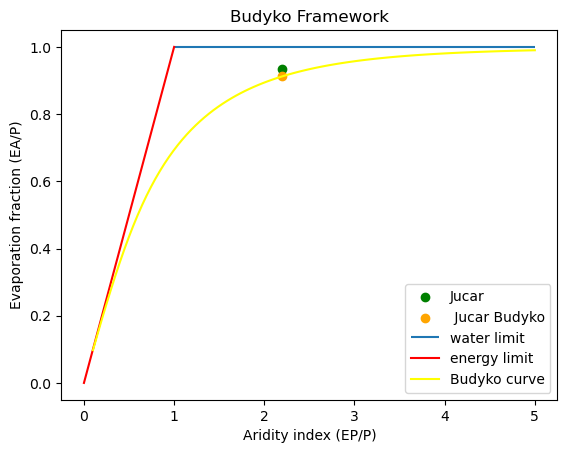

In [102]:
x = np.linspace(0,1,100)

EP_P = np.linspace(0.1,5,100)
EA_P_Bud = (EP_P*np.tanh(1/(EP_P))*(1-np.exp(-EP_P)))**(0.5)

plt.scatter(EP1_P1, EA1_P1, label = 'Jucar', color = 'green')

plt.scatter(EP1_P1, EA1_P1_Bud, label = ' Jucar Budyko', color = 'orange')

plt.title('Budyko Framework')
plt.ylabel('Evaporation fraction (EA/P)')
plt.xlabel('Aridity index (EP/P)')
plt.hlines(y = 1, xmin= 1, xmax= 5, label = 'water limit')
plt.plot(x,x, color ='red', label = 'energy limit')
plt.plot(EP_P, EA_P_Bud, color= 'yellow', label = 'Budyko curve')
plt.legend()
plt.show()

In [103]:
#Calculate the losses
EA1 = EA1_P1_Bud*P_mean
Water_balance_C1 = P_mean - EA1 - Q_mean
print(Water_balance_C1)


0.027906157189512018


Losses are expected to go to 0 (or close to it) in long times. We can see that this is not the case for our data, this can happen for different reasons:
-	Observation or data error
-	Groundwater import/export
-	Topographic divide isn’t the same as the phreatic divide


## Flow duration Curve

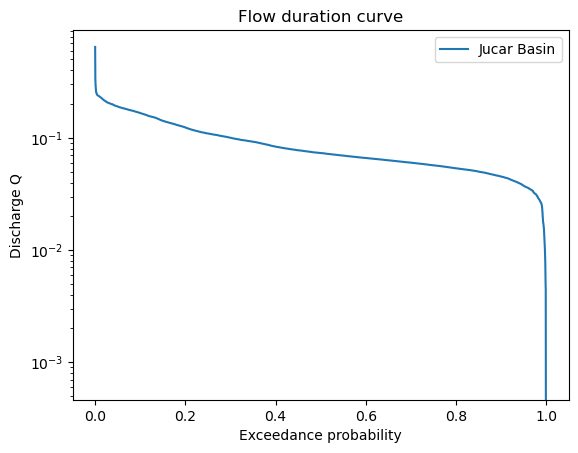

In [104]:
sorted_Q = dfQ['Q'].sort_values(ascending=False)
rank1 = np.arange(len(sorted_Q))+1
ecdf1 = rank1 / (len(sorted_Q)+1)


plt.plot(ecdf1, sorted_Q, label='Jucar Basin')
plt.xlabel('Exceedance probability')
plt.ylabel('Discharge Q')
plt.title('Flow duration curve')
plt.legend()
plt.yscale('log')

A flat flow duration curve (FDC) signals minimal flow variability, typically caused by:
- Groundwater dominance – Sustained baseflow from aquifers buffers highs/lows.
- Reservoir regulation – Dams release water at near-constant rates.


## Autocorrelation

Text(0.5, 1.0, 'Autocorrelation')

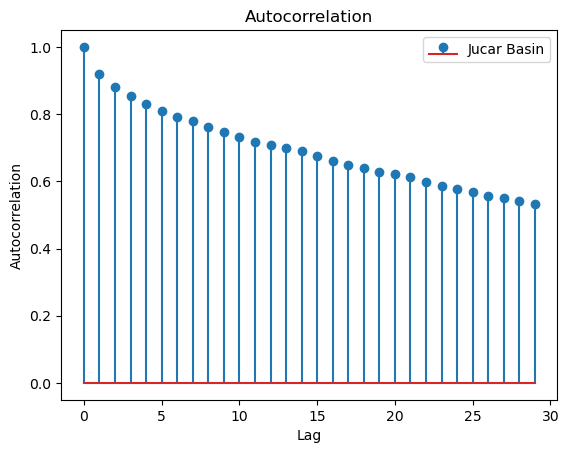

In [105]:
lags = np.arange(0, 30)
autocorrelation1 = [dfQ['Q'].autocorr(lag = i) for i in lags]
plt.stem(lags, autocorrelation1, label='Jucar Basin')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Autocorrelation')

The observed high and persistent autocorrelation in the basin’s discharge time series can be attributed to the following hydrological and anthropogenic factors:
1. Groundwater Influence (Long Hydrologic Memory): slow-draining groundwater systems release water gradually, causing discharge to reflect precipitation inputs from weeks or even months earlier.
2. Long River Routing (Slow Travel Times): in large or low-gradient basins, water takes longer to travel through the river network, smoothing out short-term variability and increasing autocorrelation.
3. Reservoir Regulation (Anthropogenic Dampening): dams store and release water according to operational rules (e.g., hydropower, irrigation), artificially reducing flow variability and amplifying autocorrelation.
